In [1]:
import time

In [146]:
# -Optional- if data in .csv have already been downloaded: import from .csv

import pandas as pd

# opcodes = pd.read_csv('opcodes50.csv', index_col=0, header=0)
# opcodes = pd.read_csv('opcodes_all.csv', index_col=0, header=0, nrows=5000)
opcodes

,opcode_str_wo_params
0,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
1,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
2,PUSH1 PUSH1 MSTORE PUSH4 PUSH1 PUSH1 EXP PUSH1...
3,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
4,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
...,...
4995,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
4996,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...
4997,PUSH1 PUSH1 MSTORE CALLDATASIZE ISZERO PUSH2 J...
4998,PUSH1 PUSH1 MSTORE PUSH1 CALLDATASIZE LT PUSH2...


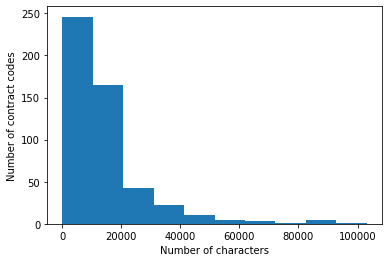

In [21]:
# Produce some contracts descriptives
# -character length
# -word count

def word_count(text):
    return len(text.split())

opcodes['code_LEN'] = opcodes.opcode_str_wo_params.apply(len)
opcodes['code_wc'] = opcodes.opcode_str_wo_params.apply(word_count)

import matplotlib.pyplot as plt
plt.hist(opcodes.code_LEN.values)
plt.xlabel('Number of characters')
plt.ylabel('Number of contract codes')
plt.show()

In [147]:
# Tokenize and Vectorize the opcode tokens

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.regexp import regexp_tokenize
import time

def renltk_tokenize(text):
    return regexp_tokenize(text,
                           pattern = '\s',
                           gaps = True)

oplist = list(opcodes.opcode_str_wo_params.values)


vect = CountVectorizer(max_features = None,
                     tokenizer = renltk_tokenize,
                     ngram_range = (1,1),
                     lowercase = False)

t1 = time.time()
%time oplist_matrix = vect.fit_transform(oplist)
t2 = time.time()

print(oplist_matrix.shape)

terms = vect.get_feature_names()

Wall time: 32.1 s
(5000, 135)


Custom Clustering

In [166]:
# create clustered dictionary or load it from .csv
from sklearn.metrics.pairwise import cosine_similarity

#set the first opcode to its own cluster and keep the cluster no. for the next cluster
clustered = {0:0}
cluster_i = 1

#optionally load the clusters from saved .csv
loaded_clustered = pd.read_csv('all_clusters.csv',index_col='opcode')
clustered = loaded_clustered.to_dict()['cluster']
cluster_i = loaded_clustered['cluster'].max() + 1

In [149]:
#the clustering...

i_was_clustered = False
ts = time.time()

for i in range(1,len(oplist)):
    for j,j_cluster in clustered.items():
        #print(i,j,j_cluster)
        similarity = cosine_similarity(oplist_matrix[(i,j),:])[0,1]
        #print(similarity)
        if similarity >= 0.90:
            clustered[i] = j_cluster
            i_was_clustered = True
            #print('clustered',i,'to',j_cluster)
            break
            
    if (i_was_clustered == False):
        clustered[i] = cluster_i
        cluster_i = cluster_i + 1
        print('clustered',i,'to new cluster',cluster_i)
    else:
        i_was_clustered = False
        
tc = time.time()
time_to_cluster = tc - ts
print('Time to cluster:',time_to_cluster)


clustered 1 to new cluster 2
clustered 2 to new cluster 3
clustered 108 to new cluster 4
clustered 143 to new cluster 5
clustered 152 to new cluster 6
clustered 288 to new cluster 7
clustered 436 to new cluster 8
clustered 526 to new cluster 9
clustered 631 to new cluster 10
clustered 683 to new cluster 11
clustered 822 to new cluster 12
clustered 879 to new cluster 13
clustered 908 to new cluster 14
clustered 1018 to new cluster 15
clustered 1112 to new cluster 16
clustered 1115 to new cluster 17
clustered 1204 to new cluster 18
clustered 1226 to new cluster 19
clustered 1378 to new cluster 20
clustered 1384 to new cluster 21
clustered 1481 to new cluster 22
clustered 1685 to new cluster 23
clustered 1778 to new cluster 24
clustered 1845 to new cluster 25
clustered 1875 to new cluster 26
clustered 1885 to new cluster 27
clustered 1955 to new cluster 28
clustered 1975 to new cluster 29
clustered 2328 to new cluster 30
clustered 2696 to new cluster 31
clustered 2831 to new cluster 32
cl

In [158]:
#save results

all_clusters = pd.DataFrame.from_dict(clustered,orient='index',columns=['cluster'])
all_clusters.index.names = ['opcode']
all_clusters.to_csv('all_clusters.csv')
all_clusters = all_clusters.reset_index()
all_clusters.describe()

,opcode,cluster
count,5000.000000,5000.000000
mean,2499.500000,0.639800
std,1443.520003,2.668835
min,0.000000,0.000000
25%,1249.750000,0.000000
50%,2499.500000,0.000000
75%,3749.250000,1.000000
max,4999.000000,44.000000


In [151]:
all_clusters

,opcode,cluster
0,0,0
1,1,1
2,2,2
3,3,0
4,4,0
...,...,...
4995,4995,0
4996,4996,0
4997,4997,1
4998,4998,1


In [23]:
# Create cosine similarity matrix

from sklearn.metrics.pairwise import cosine_similarity

%time dist = 1 - cosine_similarity(oplist_matrix)

print('Cosine similarity shape:')
print(dist.shape)

Wall time: 198 ms
Cosine similarity shape:
(500, 500)


In [18]:
# Cluster opcodes

from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(oplist_matrix)

clusters = km.labels_.tolist()

opcodes['cluster'] = clusters
print(opcodes['cluster'].value_counts())

grouped = opcodes['code_LEN'].groupby(opcodes['cluster'])
print(grouped.mean())

Wall time: 6min 57s
1    2049
4    2004
0     610
2     248
3      89
Name: cluster, dtype: int64
cluster
0    28711.591803
1     4978.746218
2    49911.814516
3    81418.146067
4    14131.873253
Name: code_LEN, dtype: float64


In [19]:
# Get the top 6 n-grams that are closest to each cluster's centroid.

print("Top opcodes per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d commands:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % terms[ind], end=',')
    print()
    print()

Top opcodes per cluster:

Cluster 0 commands: PUSH1, SWAP1, PUSH2, DUP1, POP, DUP2,

Cluster 1 commands: PUSH1, SWAP1, DUP1, PUSH2, POP, JUMPDEST,

Cluster 2 commands: PUSH1, SWAP1, POP, DUP1, PUSH2, ADD,

Cluster 3 commands: PUSH1, PUSH2, SWAP1, ADD, DUP1, POP,

Cluster 4 commands: PUSH1, SWAP1, DUP1, POP, PUSH2, DUP2,

